In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
import sys, os
sys.path.append(os.path.abspath('..'))
from pre_processamento.processamento_dados import processamento

In [3]:
df = processamento()

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
DATETIME,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,0.0,1011.0,1011.1,1010.5,21.1,14.9,21.6,21.1,15.6,14.9,69.0,67.0,68.0,123.0,6.1,2.8
2010-01-01 01:00:00,0.0,1011.2,1011.2,1011.0,20.8,14.7,21.1,20.8,15.0,14.7,69.0,68.0,68.0,119.0,6.7,1.7
2010-01-01 02:00:00,0.0,1011.1,1011.3,1011.1,20.5,14.7,20.8,20.4,14.8,14.7,70.0,68.0,70.0,122.0,6.6,2.4
2010-01-01 03:00:00,0.0,1010.9,1011.2,1010.9,20.0,14.5,20.5,20.0,14.7,14.5,71.0,69.0,71.0,123.0,6.4,2.1
2010-01-01 04:00:00,0.0,1010.2,1011.0,1010.2,19.5,14.5,20.0,19.5,14.6,14.5,73.0,71.0,73.0,124.0,5.4,1.9


Divisão entre treino, validação e teste para evitar dataleak

In [5]:
# Gerar colunas 'hora' e 'mes' a partir do índice datetime
df['hora'] = df.index.hour
df['mes'] = df.index.month

# --- Termos de Fourier para periodicidade horária (período = 24 horas) ---
def add_fourier_terms(df, period_hours=24, n_harmonics=3, prefix='fourier'):
    """Adiciona colunas sin/cos para os n_harmonics primeiros harmônicos.
    Usa horas desde o primeiro timestamp como base de tempo."""
    t = (df.index - df.index[0]).total_seconds() / 3600.0
    t = np.asarray(t)
    for k in range(1, n_harmonics + 1):
        df[f'{prefix}_{k}_sin'] = np.sin(2 * np.pi * k * t / period_hours)
        df[f'{prefix}_{k}_cos'] = np.cos(2 * np.pi * k * t / period_hours)
    return df

# Adiciona 3 harmônicos por padrão (pode ajustar se necessário)
df = add_fourier_terms(df, period_hours=24, n_harmonics=3)

# Lista de colunas de Fourier criadas
fourier_cols = [c for c in df.columns if c.startswith('fourier_')]

#Adiciona os 3 lags no df para depois fazer a divisão
df['lag_1'] = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].shift(1)
df['lag_2'] = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].shift(2)
df['lag_3'] = df['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].shift(3)

feature_cols = ['hora', 'mes', 'lag_1', 'lag_2', 'lag_3', 'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'] + fourier_cols
# --- Criar conjuntos de treino / validação / teste (por períodos) ---
# Período de treino (2010)
train_end = '2010-12-31 23:00:00'
df_train = df[feature_cols].loc[:train_end]
# Período de validação (2011)
val_end = '2011-12-31 23:00:00'
val_start = '2011-01-01 00:00:00'
df_val = df[feature_cols].loc[val_start:val_end]

# Período de teste (2012)
test_start = '2012-01-01 00:00:00'
df_test = df[feature_cols].loc[test_start:]

Visão geral das propriedades da série

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2010-01-01 00:00:00 to 2010-12-31 23:00:00
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   hora                                        8760 non-null   int32  
 1   mes                                         8760 non-null   int32  
 2   lag_1                                       8759 non-null   float64
 3   lag_2                                       8758 non-null   float64
 4   lag_3                                       8757 non-null   float64
 5   TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)  8760 non-null   float64
 6   fourier_1_sin                               8760 non-null   float64
 7   fourier_1_cos                               8760 non-null   float64
 8   fourier_2_sin                               8760 non-null   float64
 9   fourier_2_cos                               8760 

# Modelagem

Para modelagem iremos usar o modelo SARIMAX, pois iremos usar variáveis exógenas para poder auxiliar o modelo, que serão os lags 1, 2, 3, que correspondem aos valores da variável que estamos buscando a 1, 2, 3 observações anteriores

In [9]:
#geração dos lags para o modelo
df_train['lag_1'] = df_train['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].shift(1)
df_train['lag_2'] = df_train['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].shift(2)
df_train['lag_3'] = df_train['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].shift(3)
#dropamos os primeiros 3 valores do dataframe para retirar os valores faltantes dos lags
df_train = df_train.iloc[3:]
df_train.head()

,hora,mes,lag_1,lag_2,lag_3,TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),fourier_1_sin,fourier_1_cos,fourier_2_sin,fourier_2_cos,fourier_3_sin,fourier_3_cos
DATETIME,,,,,,,,,,,,
2010-01-01 03:00:00,3,1,20.8,21.1,21.6,20.5,0.707107,7.071068e-01,1.000000e+00,6.123234e-17,7.071068e-01,-7.071068e-01
2010-01-01 04:00:00,4,1,20.5,20.8,21.1,20.0,0.866025,5.000000e-01,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000e+00
2010-01-01 05:00:00,5,1,20.0,20.5,20.8,19.5,0.965926,2.588190e-01,5.000000e-01,-8.660254e-01,-7.071068e-01,-7.071068e-01
2010-01-01 06:00:00,6,1,19.5,20.0,20.5,20.0,1.000000,6.123234e-17,1.224647e-16,-1.000000e+00,-1.000000e+00,-1.836970e-16
2010-01-01 07:00:00,7,1,20.0,19.5,20.0,20.8,0.965926,-2.588190e-01,-5.000000e-01,-8.660254e-01,-7.071068e-01,7.071068e-01


Após definir os lags basta definir os parâmetros que iremos utilizar no SARIMAX, para isso iremos rodar um grid search para os parâmetros p, q, P, Q, pois o d e D já sabemos que é 0, porque não precisamos diferenciar a parte não sazonal, mas necessitamos de uma diferenciação sazonal, o que torna D = 1 e sazonalidade é 24.

In [10]:
from statsmodels.tsa.arima.model import ARIMA
import itertools

In [ ]:
p = range(0, 2)
q = range(0, 2)
Q = range(0, 2)
P = range(0, 2)
params = list(itertools.product(p, q, Q, P))
lags = [df_train['lag_1'], df_train[['lag_1', 'lag_2']], df_train[['lag_1', 'lag_2', 'lag_3']]]
results = []
for param in params:
  for lag in lags:
      model = ARIMA(df_train['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'], order=(param[0], 0, param[1]), seasonal_order=(param[2], 1, param[3], 24), exog=lag, enforce_invertibility=False, enforce_stationarity=False)
      model_fit = model.fit()
      print(f"Treinamento feito com os parâmetros: {param}. Resultado AIC: {model_fit.aic}")
      results.append((param, model_fit.aic))



Treinamento feito com os parâmetros: (0, 0, 0, 0). Resultado AIC: 13632.564998155925
Treinamento feito com os parâmetros: (0, 0, 0, 0). Resultado AIC: 13197.194446943697
Treinamento feito com os parâmetros: (0, 0, 0, 0). Resultado AIC: 13195.64793400796
Treinamento feito com os parâmetros: (0, 0, 0, 1). Resultado AIC: 11222.937534497256
Treinamento feito com os parâmetros: (0, 0, 0, 1). Resultado AIC: 10525.375215771972
Treinamento feito com os parâmetros: (0, 0, 0, 1). Resultado AIC: 10518.522602887984
Treinamento feito com os parâmetros: (0, 0, 1, 0). Resultado AIC: 12457.792919754233
Treinamento feito com os parâmetros: (0, 0, 1, 0). Resultado AIC: 11952.356618932638
Treinamento feito com os parâmetros: (0, 0, 1, 0). Resultado AIC: 11947.285210761736
Treinamento feito com os parâmetros: (0, 0, 1, 1). Resultado AIC: 11164.984818057797
Treinamento feito com os parâmetros: (0, 0, 1, 1). Resultado AIC: 10527.361557973116
Treinamento feito com os parâmetros: (0, 0, 1, 1). Resultado AIC: 

In [ ]:
#sortando os valores para pegar a melhor combinação de parâmetros
results = sorted(results, key=lambda x: x[1])
print(results[0])

((0, 1, 1, 1), np.float64(10495.00751325419))


c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo\Documents\Trabalho-de-Aprendizado-de-Maquina-e-Ciencia-de-Dados\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


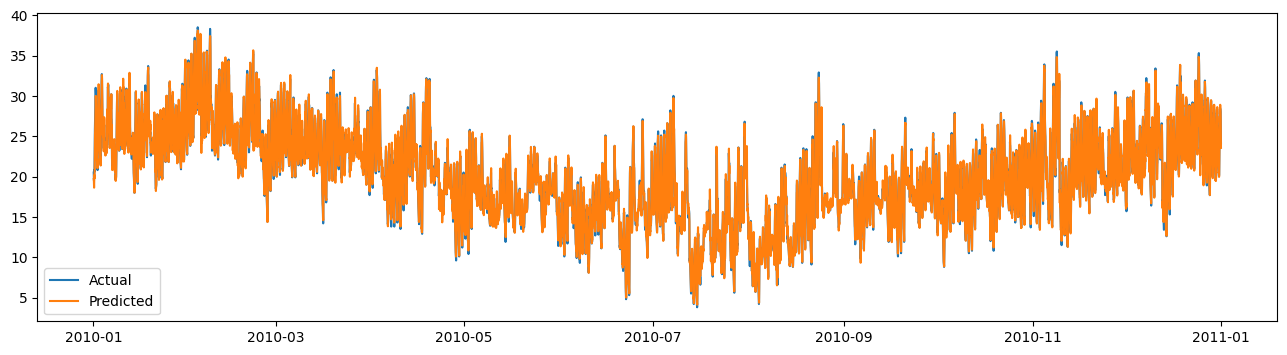

In [12]:
exog_temp = df_train.drop(columns=['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)', 'lag_1', 'lag_2', 'lag_3'])
# for lag in lags:
model = ARIMA(df_train['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 24), exog = df_train['lag_1'], enforce_invertibility=False, enforce_stationarity=False)
model_fit = model.fit()
previsao_treino = model_fit.predict(start=0, end=len(df_train)-1)
plt.figure(figsize=(16,4))
plt.plot(df_train['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'], label="Actual")
plt.plot(previsao_treino, label="Predicted")
plt.legend()


Como não houve diferença no treino, iremos utilizar o modelo com lag 1, que seria o mais abrangente

Ajustando o conjunto de validação

In [13]:
df_val.head()

,hora,mes,lag_1,lag_2,lag_3,TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),fourier_1_sin,fourier_1_cos,fourier_2_sin,fourier_2_cos,fourier_3_sin,fourier_3_cos
DATETIME,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,24.1,25.2,26.8,22.8,-3.665109e-13,1.000000,-7.330218e-13,1.000000e+00,-6.447853e-13,1.000000e+00
2011-01-01 01:00:00,1,1,22.8,24.1,25.2,22.3,2.588190e-01,0.965926,5.000000e-01,8.660254e-01,7.071068e-01,7.071068e-01
2011-01-01 02:00:00,2,1,22.3,22.8,24.1,21.7,5.000000e-01,0.866025,8.660254e-01,5.000000e-01,1.000000e+00,4.796453e-13
2011-01-01 03:00:00,3,1,21.7,22.3,22.8,21.4,7.071068e-01,0.707107,1.000000e+00,-3.416129e-13,7.071068e-01,-7.071068e-01
2011-01-01 04:00:00,4,1,21.4,21.7,22.3,21.2,8.660254e-01,0.500000,8.660254e-01,-5.000000e-01,-5.949893e-13,-1.000000e+00


Prevendo no conjunto de validação

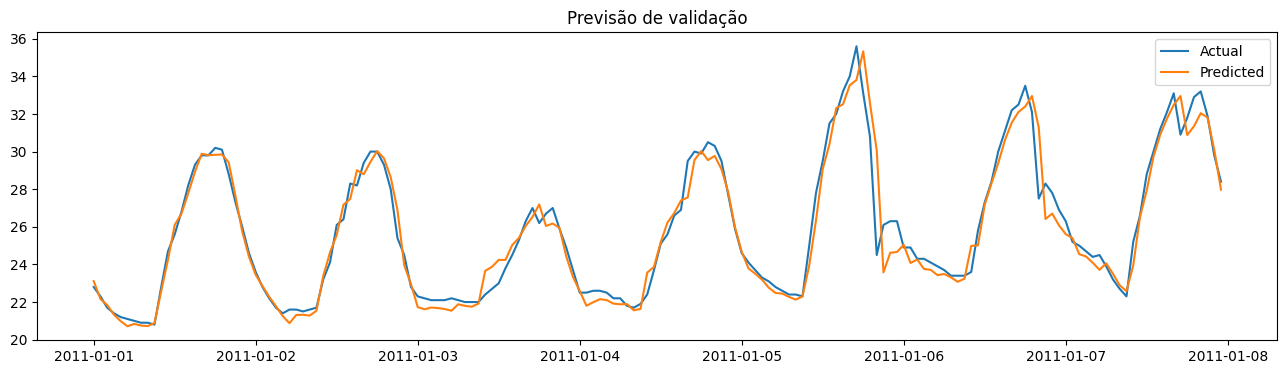

In [14]:
previsao_val = model_fit.predict(start=len(df_train), end=(len(df_train) + len(df_val))-1, exog=df_val['lag_1'])
plt.figure(figsize=(16,4))
plt.plot(df_val['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].iloc[:168], label="Actual")
plt.plot(previsao_val.iloc[:168], label="Predicted")
plt.title(f"Previsão de validação")
plt.legend()

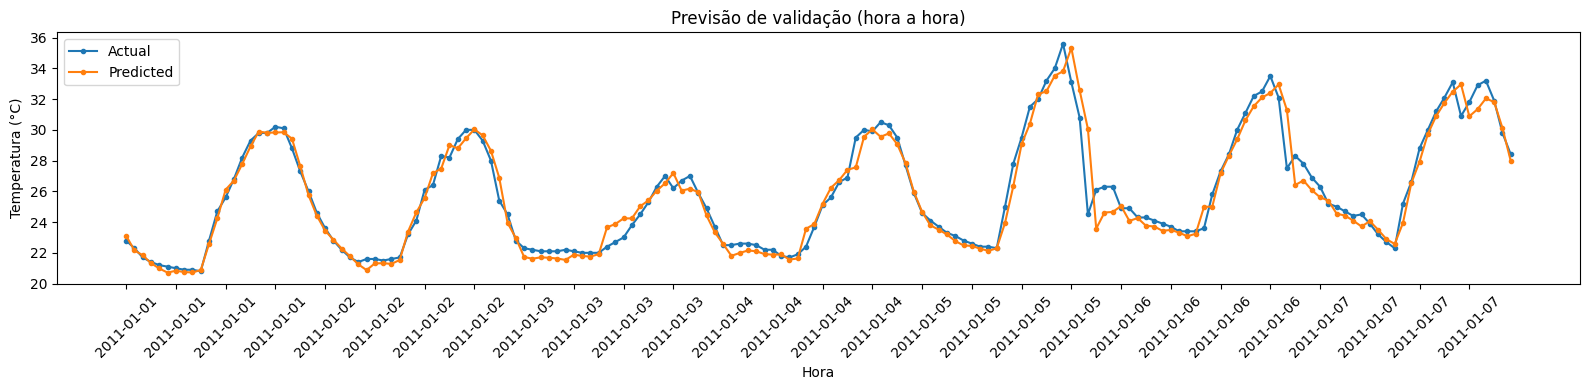

In [15]:
n = 168

plt.figure(figsize=(16,4))

plt.plot(
    df_val.index[:n],
    df_val['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].iloc[:n],
    label="Actual",
    marker='o',
    markersize=3
)

plt.plot(
    df_val.index[:n],
    previsao_val.iloc[:n],
    label="Predicted",
    marker='o',
    markersize=3
)

plt.title("Previsão de validação (hora a hora)")
plt.xlabel("Hora")
plt.ylabel("Temperatura (°C)")
plt.legend()

# Mostra uma marca a cada 6 horas (ajuste se quiser)
plt.xticks(df_val.index[:n:6], rotation=45)

plt.tight_layout()
plt.show()


In [16]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(df_val['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'], previsao_val)))

0.8761500812973902


In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                            
======================================================================================================
Dep. Variable:     TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)   No. Observations:                 5253
Model:                           ARIMA(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood               -5397.755
Date:                                        Mon, 15 Dec 2025   AIC                          10811.510
Time:                                                14:22:37   BIC                          10863.965
Sample:                                            01-01-2010   HQIC                         10829.857
                                                 - 08-07-2010                                         
Covariance Type:                                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lag_1          1.1609      0.423      2.747      0.006       0.333       1.989
lag_2         -0.1133      0.601     -0.189      0.850      -1.291       1.064
lag_3         -0.0811      0.190     -0.426      0.670      -0.454       0.292
ar.L1         -0.3769      0.954     -0.395      0.693      -2.246       1.492
ma.L1          2.1361      2.454      0.870      0.384      -2.674       6.946
ar.S.L24       0.0828      0.012      7.165      0.000       0.060       0.106
ma.S.L24      -1.0529      0.005   -206.064      0.000      -1.063      -1.043
sigma2         0.0912      0.210      0.435      0.664      -0.320       0.502
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             15458.28
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Avaliação no conjunto de teste



K-FOLD VALIDATION COM SARIMAX (SEM LAGS COMO EXÓGENAS)

Número de folds: 5
Tamanho total (treino + validação): 17517 observações

--- FOLD 1 ---
Treino: 2922 obs | Teste: 2919 obs
RMSE: 6.4957 | MAE: 5.4345 | MAPE: 44.88% | R²: -1.1031

--- FOLD 2 ---
Treino: 5841 obs | Teste: 2919 obs
RMSE: 5.5535 | MAE: 4.4553 | MAPE: 20.09% | R²: -0.4245

--- FOLD 3 ---
Treino: 8760 obs | Teste: 2919 obs
RMSE: 3.2101 | MAE: 2.5879 | MAPE: 11.46% | R²: 0.3928

--- FOLD 4 ---
Treino: 11679 obs | Teste: 2919 obs
RMSE: 6.8312 | MAE: 5.7562 | MAPE: 54.25% | R²: -1.2262

--- FOLD 5 ---
Treino: 14598 obs | Teste: 2919 obs
RMSE: 7.3918 | MAE: 6.4225 | MAPE: 29.29% | R²: -1.2069


RESUMO DOS K-FOLD RESULTS (SEM VARIÁVEIS EXÓGENAS)

 fold     rmse      mae      mape        r2  n_train  n_test
    1 6.495694 5.434480 44.883000 -1.103112     2922    2919
    2 5.553481 4.455343 20.085262 -0.424502     5841    2919
    3 3.210100 2.587884 11.458428  0.392786     8760    2919
    4 6.831163 5.756200 54.250567 -1

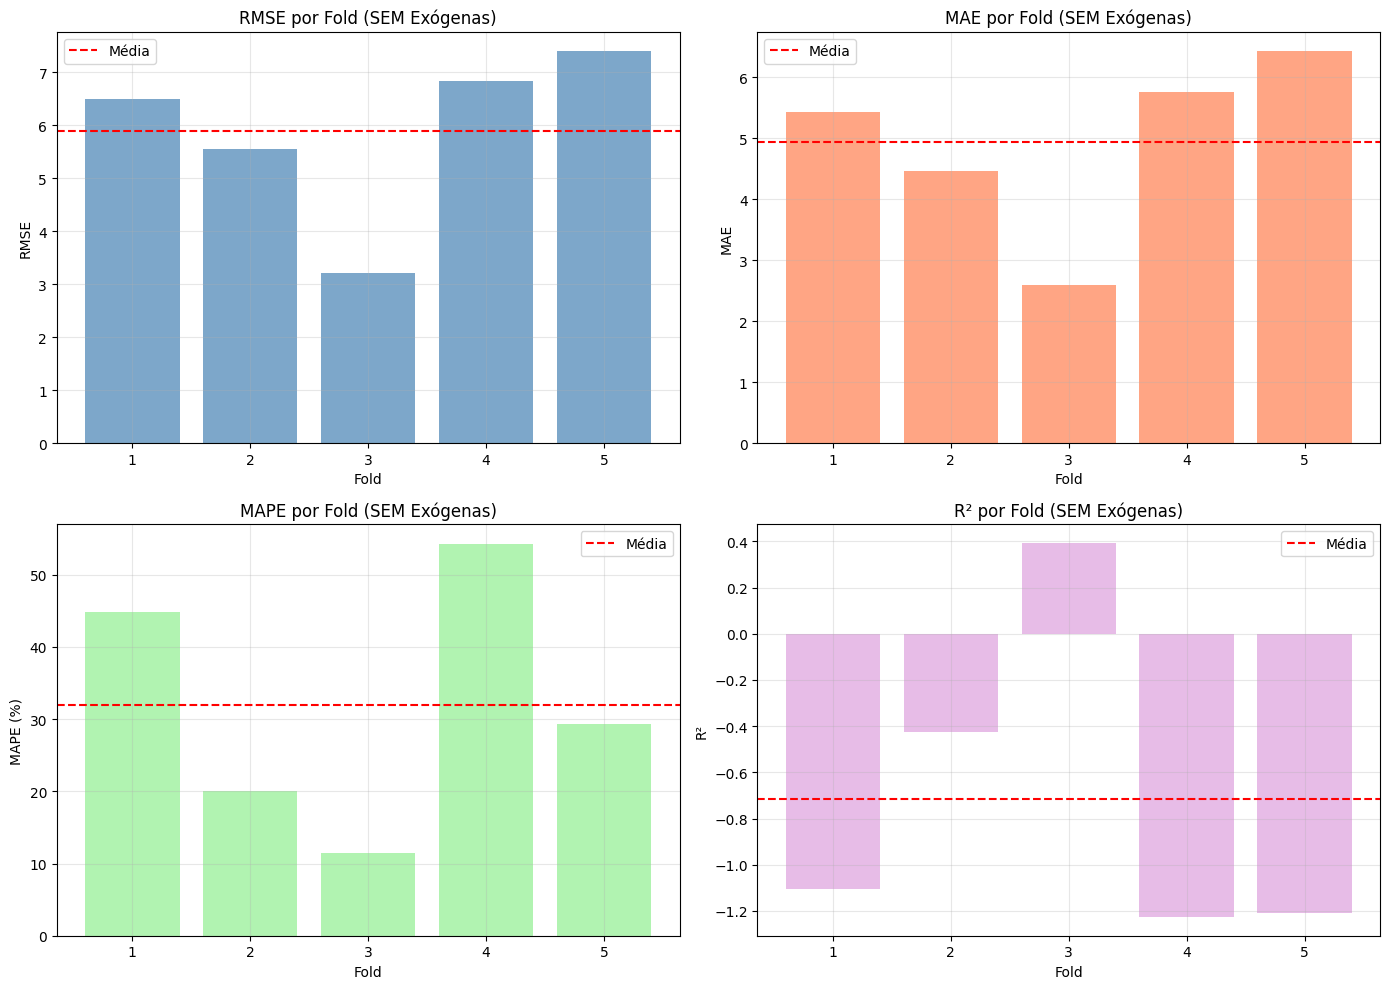


CONCLUSÃO: Comparar estes resultados com os resultados COM lags


In [27]:
# --- K-FOLD COM SARIMAX (SEM VARIÁVEIS EXÓGENAS) ---
print("\n" + "="*80)
print("K-FOLD VALIDATION COM SARIMAX (SEM LAGS COMO EXÓGENAS)")
print("="*80 + "\n")

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Combinar treino + validação para aplicar k-fold
df_train_val = pd.concat([df_train[['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)']], 
                           df_val[['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)']]])

y_combined = df_train_val['TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)'].values

# Configurar TimeSeriesSplit com k=5 folds
tscv = TimeSeriesSplit(n_splits=5)

# Armazenar resultados de cada fold
fold_results = []

print(f"Número de folds: {tscv.get_n_splits()}")
print(f"Tamanho total (treino + validação): {len(y_combined)} observações\n")

# Iterar sobre cada fold
for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(y_combined), 1):
    print(f"--- FOLD {fold_idx} ---")
    
    # Separar dados de treino e teste para este fold
    y_train_fold = y_combined[train_idx]
    y_test_fold = y_combined[test_idx]
    
    print(f"Treino: {len(y_train_fold)} obs | Teste: {len(y_test_fold)} obs")
    
    try:
        # Treinar SARIMAX SEM variáveis exógenas
        # order=(p,d,q), seasonal_order=(P,D,Q,s)
        model_fold = ARIMA(
            y_train_fold,
            order=(1, 0, 1),
            seasonal_order=(1, 1, 1, 24),
            enforce_invertibility=False,
            enforce_stationarity=False
        )
        
        model_fold_fit = model_fold.fit()
        
        # Fazer previsões no conjunto de teste deste fold
        # start = len(treino), end = len(treino) + len(teste) - 1
        y_pred_fold = model_fold_fit.predict(
            start=len(y_train_fold),
            end=len(y_train_fold) + len(y_test_fold) - 1
        )
        
        # Calcular métricas
        rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
        mae = mean_absolute_error(y_test_fold, y_pred_fold)
        mape = np.mean(np.abs((y_test_fold - y_pred_fold) / y_test_fold)) * 100
        r2 = r2_score(y_test_fold, y_pred_fold)
        
        fold_results.append({
            'fold': fold_idx,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'r2': r2,
            'n_train': len(y_train_fold),
            'n_test': len(y_test_fold)
        })
        
        print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R²: {r2:.4f}")
        print()
        
    except Exception as e:
        print(f"Erro no fold {fold_idx}: {e}\n")

# Consolidar resultados em DataFrame
df_fold_results = pd.DataFrame(fold_results)

print("\n" + "="*80)
print("RESUMO DOS K-FOLD RESULTS (SEM VARIÁVEIS EXÓGENAS)")
print("="*80 + "\n")

print(df_fold_results.to_string(index=False))

print(f"\n--- MÉTRICAS AGREGADAS ---")
print(f"RMSE médio:  {df_fold_results['rmse'].mean():.4f} ± {df_fold_results['rmse'].std():.4f}")
print(f"MAE médio:   {df_fold_results['mae'].mean():.4f} ± {df_fold_results['mae'].std():.4f}")
print(f"MAPE médio:  {df_fold_results['mape'].mean():.2f}% ± {df_fold_results['mape'].std():.2f}%")
print(f"R² médio:    {df_fold_results['r2'].mean():.4f} ± {df_fold_results['r2'].std():.4f}")

# Visualizar resultados
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMSE por fold
axes[0, 0].bar(df_fold_results['fold'], df_fold_results['rmse'], color='steelblue', alpha=0.7)
axes[0, 0].axhline(df_fold_results['rmse'].mean(), color='red', linestyle='--', label='Média')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('RMSE por Fold (SEM Exógenas)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MAE por fold
axes[0, 1].bar(df_fold_results['fold'], df_fold_results['mae'], color='coral', alpha=0.7)
axes[0, 1].axhline(df_fold_results['mae'].mean(), color='red', linestyle='--', label='Média')
axes[0, 1].set_xlabel('Fold')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('MAE por Fold (SEM Exógenas)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# MAPE por fold
axes[1, 0].bar(df_fold_results['fold'], df_fold_results['mape'], color='lightgreen', alpha=0.7)
axes[1, 0].axhline(df_fold_results['mape'].mean(), color='red', linestyle='--', label='Média')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].set_title('MAPE por Fold (SEM Exógenas)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# R² por fold
axes[1, 1].bar(df_fold_results['fold'], df_fold_results['r2'], color='plum', alpha=0.7)
axes[1, 1].axhline(df_fold_results['r2'].mean(), color='red', linestyle='--', label='Média')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('R²')
axes[1, 1].set_title('R² por Fold (SEM Exógenas)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("CONCLUSÃO: Comparar estes resultados com os resultados COM lags")
print("="*80)
